In [17]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score

# Any results you write to the current directory are saved as output.

['test.csv', 'train.csv', 'sample_submission.csv']


In [18]:
train_df = pd.read_csv('../input/train.csv')
test_df = pd.read_csv('../input/test.csv')

In [19]:
train_df.head()

,id,muggy-smalt-axolotl-pembus,dorky-peach-sheepdog-ordinal,slimy-seashell-cassowary-goose,snazzy-harlequin-chicken-distraction,frumpy-smalt-mau-ordinal,stealthy-beige-pinscher-golden,chummy-cream-tarantula-entropy,hazy-emerald-cuttlefish-unsorted,nerdy-indigo-wolfhound-sorted,leaky-amaranth-lizard-sorted,ugly-tangerine-chihuahua-important,shaggy-silver-indri-fimbus,flaky-chocolate-beetle-grandmaster,squirrely-harlequin-sheep-sumble,freaky-tan-angelfish-noise,lousy-plum-penguin-sumble,bluesy-rose-wallaby-discard,baggy-copper-oriole-dummy,stealthy-scarlet-hound-fepid,greasy-cinnamon-bonobo-contributor,cranky-cardinal-dogfish-ordinal,snippy-auburn-vole-learn,greasy-sepia-coral-dataset,flabby-tangerine-fowl-entropy,lousy-smalt-pinscher-dummy,bluesy-brass-chihuahua-distraction,goopy-eggplant-indri-entropy,homey-sepia-bombay-sorted,homely-ruby-bulldog-entropy,hasty-blue-sheep-contributor,blurry-wisteria-oyster-master,snoopy-auburn-dogfish-expert,stinky-maroon-blue-kernel,bumpy-amaranth-armadillo-important,slaphappy-peach-oyster-master,dorky-tomato-ragdoll-dataset,messy-mauve-wolverine-ordinal,geeky-pumpkin-moorhen-important,crabby-teal-otter-unsorted,...,beady-mauve-frog-distraction,surly-brass-maltese-ordinal,beady-asparagus-opossum-expert,beady-rust-impala-dummy,droopy-amethyst-dachshund-hint,homey-crimson-budgerigar-grandmaster,droopy-cardinal-impala-important,woozy-apricot-moose-hint,paltry-sapphire-labradoodle-dummy,crappy-carmine-eagle-entropy,greasy-magnolia-spider-grandmaster,crabby-carmine-flounder-sorted,skimpy-copper-fowl-grandmaster,hasty-seashell-woodpecker-hint,snappy-purple-bobcat-important,thirsty-carmine-corgi-ordinal,homely-auburn-reindeer-unsorted,crappy-beige-tiger-fepid,cranky-auburn-swan-novice,chewy-bistre-buzzard-expert,skinny-cyan-macaque-pembus,slimy-periwinkle-otter-expert,snazzy-burgundy-clam-novice,cozy-ochre-gorilla-gaussian,homey-sangria-wolfhound-dummy,snazzy-asparagus-hippopotamus-contributor,paltry-red-hamster-sorted,zippy-dandelion-insect-golden,baggy-coral-bandicoot-unsorted,goopy-lavender-wolverine-fimbus,wheezy-myrtle-mandrill-entropy,wiggy-lilac-lemming-sorted,gloppy-cerise-snail-contributor,woozy-silver-havanese-gaussian,jumpy-thistle-discus-sorted,muggy-turquoise-donkey-important,blurry-buff-hyena-entropy,bluesy-chocolate-kudu-fepid,gamy-white-monster-expert,target
0,707b395ecdcbb4dc2eabea00e4d1b179,-2.070654,1.018160,0.228643,0.857221,0.052271,0.230303,-6.385090,0.439369,-0.721946,-0.227027,0.575964,1.541908,1.745286,-0.624271,3.600958,1.176489,-0.182776,-0.228391,1.682263,-0.833236,-4.377688,-5.372410,-0.477742,-0.179005,-0.516475,0.127391,-0.857591,-0.461500,2.160303,-2.118371,0.515493,-1.201493,-0.027377,-1.154024,0.753204,-0.179651,-0.807341,-1.663626,0.893806,...,-1.829848,2.347131,0.082462,-1.012654,0.593752,2.904654,-0.428974,-0.919979,2.849575,-0.906744,0.729459,0.386140,0.319814,-0.407682,-0.170667,-1.242919,-1.719046,-0.132395,-0.368991,-5.112553,-2.085988,-0.897257,1.080671,-0.273262,0.342824,0.640177,-0.415298,-0.483126,-0.080799,2.416224,0.351895,0.618824,-1.542423,0.598175,0.611757,0.678772,0.247059,-0.806677,-0.193649,0
1,5880c03c6582a7b42248668e56b4bdec,-0.491702,0.082645,-0.011193,1.071266,-0.346347,-0.082209,0.110579,-0.382374,-0.229620,0.783980,-1.280579,-1.003480,-7.753201,-1.320547,0.919078,-1.036068,0.030213,0.910172,-0.905345,0.646641,-0.465291,-0.531735,-0.756781,0.193724,0.224277,-0.474412,1.885805,0.205439,-6.481422,1.035620,-0.453623,0.375936,-0.320670,-0.144646,-0.220129,0.577826,-0.360512,-0.600107,0.008111,...,0.982205,-1.161978,0.532269,1.133215,0.003503,-1.390962,0.158572,0.143794,-0.317185,1.017192,-0.395342,-0.642357,-0.627209,0.257271,-1.461564,0.325613,1.628369,0.640040,0.750735,1.164573,0.900373,0.063489,0.948158,0.273014,-1.269147,-0.251101,-2.271731,-0.044167,-0.443766,-1.144794,-0.645115,-1.246090,2.613357,-0.479664,1.581289,0.931258,0.151937,-0.766595,0.474351,0
2,4ccbcb3d13e5072ff1d9c61afe2c4f77,-1.680473,0.860529,-1.076195,0.740124,3.678445,0.28855

In [20]:
cols = [c for c in train_df.columns if c not in ['id', 'target']]
print(cols)

['muggy-smalt-axolotl-pembus', 'dorky-peach-sheepdog-ordinal', 'slimy-seashell-cassowary-goose', 'snazzy-harlequin-chicken-distraction', 'frumpy-smalt-mau-ordinal', 'stealthy-beige-pinscher-golden', 'chummy-cream-tarantula-entropy', 'hazy-emerald-cuttlefish-unsorted', 'nerdy-indigo-wolfhound-sorted', 'leaky-amaranth-lizard-sorted', 'ugly-tangerine-chihuahua-important', 'shaggy-silver-indri-fimbus', 'flaky-chocolate-beetle-grandmaster', 'squirrely-harlequin-sheep-sumble', 'freaky-tan-angelfish-noise', 'lousy-plum-penguin-sumble', 'bluesy-rose-wallaby-discard', 'baggy-copper-oriole-dummy', 'stealthy-scarlet-hound-fepid', 'greasy-cinnamon-bonobo-contributor', 'cranky-cardinal-dogfish-ordinal', 'snippy-auburn-vole-learn', 'greasy-sepia-coral-dataset', 'flabby-tangerine-fowl-entropy', 'lousy-smalt-pinscher-dummy', 'bluesy-brass-chihuahua-distraction', 'goopy-eggplant-indri-entropy', 'homey-sepia-bombay-sorted', 'homely-ruby-bulldog-entropy', 'hasty-blue-sheep-contributor', 'blurry-wisteria-

In [21]:
#cols.remove('wheezy-copper-turtle-magic')
interactions = np.zeros((512,255))
oof = np.zeros(len(train_df))
preds = np.zeros(len(test_df))

In [22]:
for i in range(512):
    # ONLY TRAIN WITH DATA WHERE WHEEZY EQUALS I
    train2 = train_df[train_df['wheezy-copper-turtle-magic']==i]
    test2 = test_df[test_df['wheezy-copper-turtle-magic']==i]
    idx1 = train2.index; idx2 = test2.index
    train2.reset_index(drop=True,inplace=True)
    test2.reset_index(drop=True,inplace=True)
    
    skf = StratifiedKFold(n_splits=25, random_state=42)
    for train_index, test_index in skf.split(train2.iloc[:,1:-1], train2['target']):
        # LOGISTIC REGRESSION MODEL
        clf = LogisticRegression(solver='liblinear',penalty='l1',C=0.05)
        clf.fit(train2.loc[train_index][cols],train2.loc[train_index]['target'])
        oof[idx1[test_index]] += clf.predict_proba(train2.loc[test_index][cols])[:,1]
        preds[idx2] += clf.predict_proba(test2[cols])[:,1]
        # RECORD INTERACTIONS
        for j in range(255):
            if clf.coef_[0][j]>0: interactions[i,j] = 1
            elif clf.coef_[0][j]<0: interactions[i,j] = -1
    if i%25==0: print(i)

0
25
50
75
100
125
150
175
200
225
250
275
300
325
350
375
400
425
450
475
500


In [23]:
# PRINT CV AUC
auc = roc_auc_score(train_df['target'],oof)
print('LR with interactions scores CV =',round(auc,5))

LR with interactions scores CV = 0.80626


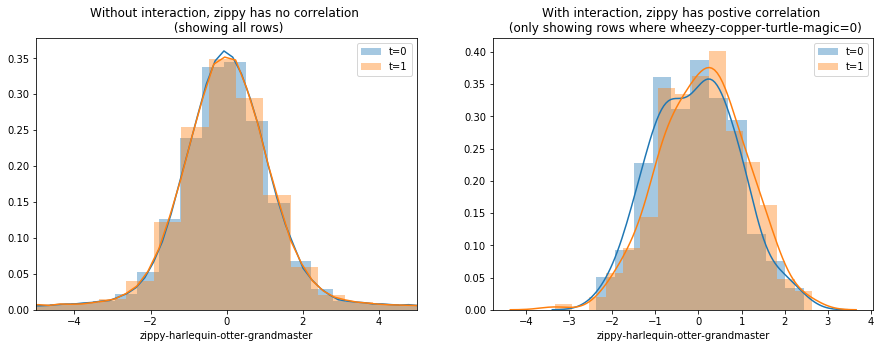

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

plt.figure(figsize=(15,5))

# PLOT ALL ZIPPY
plt.subplot(1,2,1)
sns.distplot(train_df[ (train_df['target']==0) ]['zippy-harlequin-otter-grandmaster'], label = 't=0')
sns.distplot(train_df[ (train_df['target']==1) ]['zippy-harlequin-otter-grandmaster'], label = 't=1')
plt.title("Without interaction, zippy has no correlation \n (showing all rows)")
plt.xlim((-5,5))
plt.legend()

# PLOT ZIPPY WHERE WHEEZY-MAGIC=0
plt.subplot(1,2,2)
sns.distplot(train_df[ (train_df['wheezy-copper-turtle-magic']==0) & (train_df['target']==0) ]
             ['zippy-harlequin-otter-grandmaster'], label = 't=0')
sns.distplot(train_df[ (train_df['wheezy-copper-turtle-magic']==0) & (train_df['target']==1) ]
             ['zippy-harlequin-otter-grandmaster'], label = 't=1')
plt.title("With interaction, zippy has postive correlation \n (only showing rows where wheezy-copper-turtle-magic=0)")
plt.legend()

plt.show()

In [25]:
sub = pd.read_csv('../input/sample_submission.csv')
sub['target'] = preds
sub.to_csv('submission.csv',index=False)